In [1]:
%load_ext autoreload
%autoreload 2

#### max activations file

In [2]:
import pickle

#max_activations = pickle.load(open('max_activation_patches.pkl','rb'))
max_activations = pickle.load(open('../cnn_subgraph_visualizer/prepped_models/alexnet_sparse/misc_data/all_max_activations.pkl','rb'))

import os
image_names = os.listdir(max_activations['image_folder'])
image_names.sort()

#### generate target max image data

In [3]:
nodeid = 1057
from circuit_pruner.utils import filterid_2_perlayerid
layer_num,unit,layer = filterid_2_perlayerid(nodeid,model)
feature_targets = {layer:[unit]}

from PIL import Image
from sklearn.manifold import TSNE
import hdbscan
import seaborn as sns
import matplotlib.pyplot as plt

image_root_folder = 'image_data/sample_data/polysemantic/'+layer+':'+str(unit)

if os.path.exists(image_root_folder):
    raise ValueError('image folder %s already exists.'%image_root_folder)
 

os.mkdir(image_root_folder)

#activations of layer to top image patches    
patch_acts = pickle.load(open('/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/misc_data/maxpatch_layer_activations/'+str(nodeid)+'_top300.pkl','rb'))

#show clustered projection of activations

clusterer = hdbscan.HDBSCAN(min_cluster_size=10).fit(patch_acts)
projection = TSNE().fit_transform(patch_acts)
color_palette = sns.color_palette()
cluster_colors = [color_palette[x] if x >= 0
          else (0.5, 0.5, 0.5)
          for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                 zip(cluster_colors, clusterer.probabilities_)]
plt.scatter(*projection.T, s=20, linewidth=0, c=cluster_member_colors, alpha=0.7)
plt.show()


select_data_acts = max_activations['layer']['conv'+str(layer_num)][0][:,unit]
select_data_positions = max_activations['layer']['conv'+str(layer_num)][1][:,unit,:]

top_activations = torch.topk(torch.DoubleTensor(select_data_acts),300)


cluster_indices = {}
for j in range(300):
    clust_i = int(clusterer.labels_[j])
    if clust_i >= 0:
        if clust_i not in cluster_indices.keys():
            cluster_indices[clust_i] = [j]
        else:
            cluster_indices[clust_i].append(j)

for clust in cluster_indices:
    image_folder = image_root_folder+'/cluster_'+str(clust)
    if not os.path.exists(image_folder):
        os.mkdir(image_folder)
    print('cluster %s images: %s'%(str(clust),str(len(cluster_indices[clust]))))
    count = 0
    for ind in cluster_indices[clust]:

            image_path = max_activations['image_folder']+'/'+image_names[int(top_activations.indices[ind])]
            position = (int(select_data_positions[top_activations.indices[ind],0]),int(select_data_positions[top_activations.indices[ind],1]))
            #print(select_data_acts[top_activations.indices[ind]])
            #print(position)
            #display_image_patch_for_activation(image_path,layer,position,frame=True)
            img = Image.open(image_path)
            #display(img)
            img_name = str(count)+'.jpg'
            img.save(image_folder+'/'+img_name)
            #print('\n\n')
            count += 1




NameError: name 'model' is not defined

#### model

In [110]:
#hardware
device = 'cuda:0'

from circuit_pruner.utils import load_config

config = load_config('/mnt/data/chris/dropbox/Research-Hamblin/Projects/circuit_pruner_cvpr2022/configs/alexnet_sparse_config.py')
model = config.model.to(device)



#general
import torch
import os
from copy import deepcopy
from circuit_pruner.force import setup_net_for_circuit_prune, show_model_layer_names

#### feature target

In [112]:
nodeid = 905

from circuit_pruner.utils import filterid_2_perlayerid

layer_num,unit,layer = filterid_2_perlayerid(nodeid,model)

feature_targets = {layer:[unit]}

In [113]:
feature_targets

{'features_10': [9]}

#### extract general circuit

In [114]:
import os

general_ranks_folder = 'circuit_ranks/alexnet_sparse/imagenet_2/actxgrad/'
general_rank_files = os.listdir(general_ranks_folder)
for file in general_rank_files:
    if '_'+layer+':'+str(unit)+'_' in file:
        print('found')
        general_ranks = torch.load(general_ranks_folder+file)
        break

found


In [83]:
import pickle
df = pickle.load(open('./extracted_circuits/circuit_with20force_df.pkl','rb'))

In [84]:
df.loc[(df['model']=='alexnet_sparse') & (df['layer']==layer) & (df['method']=='actxgrad') & (df['unit']==unit)][['sparsity','effective_sparsity','pruned_pearson']]

,sparsity,effective_sparsity,pruned_pearson
31782,0.001,0.000038,0.141962
31783,0.005,0.001754,0.252371
31784,0.010,0.005277,0.301975
31785,0.050,0.045890,0.140092
31786,0.100,0.099406,0.503945
31787,0.200,0.199840,0.838351
31788,0.300,0.299917,0.964347
31789,0.400,0.399988,0.995799
31790,0.500,0.499897,0.999939
31791,0.600,0.599785,0.999999


In [85]:
from circuit_pruner.extraction import model_ranks_2_circuit_model
from circuit_pruner.utils import circuit_2_model_sparsity

sparsity = .5

general_circuit,general_mask = model_ranks_2_circuit_model(general_ranks,sparsity,model,
                                                                     feature_targets,device,structure='edges',
                                                                     use_effective_mask=True)

general_circuit = general_circuit.eval().to('cpu')

for l in general_mask:
    l = l.to('cpu')
    
    
circuit_feature_targets = {layer:[0]}
circuit_unit = 0

general_circuit_sparsity_factor = circuit_2_model_sparsity(general_circuit,model)

features_10 effective last layer
target sparsity: 0.5
total params to feature: 184768

kept params in original mask: 92384      (total params * sparsity)
original mask: 1018231 params
effective mask: 1018060 params
effective_sparsity: 0.49989175614825077
filter sparsity: 0.8249696917215102
kernel sparsity: 0.6059516624242265


In [86]:
general_circuit_sparsity_factor

0.49989175614825077

###### or use model instead of general circuit

In [122]:
# circuit_feature_targets = {layer:[unit]}
# general_circuit = model
# circuit_unit = unit
# general_circuit_sparsity_factor = 1

#### feature visualization of circuit

------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 
        8               [13, 13]       15.5       16.0            99.0 
        9               [13, 13]       15.5       16.0           131.0 
        10              [13, 13]       15.5       16.0           131.0 
        11              [13, 13]       15.5       16.0   

100%|██████████| 512/512 [00:21<00:00, 23.50it/s]



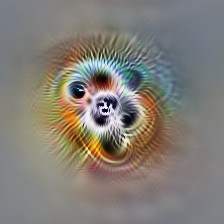

(13, 13)
(6, 6)
[(30.0, 193.0), (30.0, 193.0)]


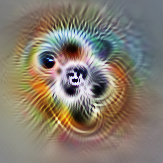

In [135]:
from circuit_pruner.visualizer.featureviz  import featviz_in_recep_field


featviz_in_recep_field(deepcopy(general_circuit),layer,circuit_unit,margin=0)

#### dataloading

In [115]:
image_root_folder = 'image_data/sample_data/polysemantic/'+layer+':'+str(unit)
#clusters = os.listdir(image_root_folder)
clusters = ['cluster_0','cluster_1']
#clusters = ['mixed_0','mixed_1']

from circuit_pruner.data_loading import rank_image_data
from circuit_pruner.data_loading import single_image_data
from torchvision import transforms
from torch.utils import data


dataloaders = {}

#make 'general' filter dataloader
kwargs = {'num_workers': 4, 'pin_memory': True, 'sampler':None} if 'cuda' in device else {}


for cluster in clusters:

    dataloaders[cluster] = data.DataLoader(rank_image_data(image_root_folder+'/'+cluster,
                                            config.preprocess,
                                            class_folders=False),
                                            batch_size=5,
                                            shuffle=False,
                                            **kwargs)



#### generate ranks

In [116]:
from circuit_pruner.dissected_Conv2d import set_across_model, set_model_target_node
from circuit_pruner.dissected_Conv2d import get_ranklist_from_dissected_Conv2d_modules, clear_ranks_across_model
from copy import deepcopy
from circuit_pruner.dissected_Conv2d import dissect_model

structure = 'kernels'

ranks = {}


for cluster in clusters:
    print(cluster)
    
    rankable_model = dissect_model(deepcopy(general_circuit), dissect=True,store_ranks = True, device=device)
    rankable_model.to(device)

    set_model_target_node(rankable_model,layer,circuit_unit)

    #we want to get ranks with respect to the maximum activation in each image, these why these image sets
    #where constructed, and its based on these activation locations that the images were clustered
    set_across_model(rankable_model,'rank_field','max')
    

    set_across_model(rankable_model,'absolute_rank',True)
    
    iter_dataloader = iter(dataloaders[cluster])
    iters = len(iter_dataloader)

    #actually extract ranks by running images through model
    clear_ranks_across_model(rankable_model)

    for it in range(iters):

        inputs, label = next(iter_dataloader)
        inputs = inputs.to(device)

        rankable_model.zero_grad()

        try:
            outputs = rankable_model(inputs)
        except:
            pass


    ranks[cluster] = get_ranklist_from_dissected_Conv2d_modules(rankable_model)
    
    del rankable_model
    torch.cuda.empty_cache()

cluster_0
cluster_1


In [117]:
from circuit_pruner.ranks import minmax_norm_ranks

normed_ranks = {}
for cluster in clusters:
    normed_ranks[cluster] = minmax_norm_ranks(ranks[cluster])

In [64]:
general_circuit

Sequential(
  (features_0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (features_1): ReLU(inplace=True)
  (features_2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (features_3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (features_4): ReLU(inplace=True)
  (features_5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (features_6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (features_7): ReLU(inplace=True)
  (features_8): Conv2d(384, 172, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (features_9): ReLU(inplace=True)
  (features_10): Conv2d(172, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

#### activation preservation as function of sparsity

##### dataloaders with larger batchsize

In [118]:
dataloaders = {}

#make 'general' filter dataloader
kwargs = {'num_workers': 4, 'pin_memory': True, 'sampler':None} if 'cuda' in device else {}


for cluster in clusters:

    dataloaders[cluster] = data.DataLoader(rank_image_data(image_root_folder+'/'+cluster,
                                            config.preprocess,
                                            class_folders=False),
                                            batch_size=40,
                                            shuffle=False,
                                            **kwargs)


In [32]:
from circuit_pruner.extraction import get_preservation_at_sparsities
import numpy as np

ranker = normed_ranks

structure='kernels'

sparsities = np.linspace(.9999, .01, num=70)



model_sparsities = []
for sparsity in sparsities:
    model_sparsities.append(sparsity*general_circuit_sparsity_factor) 


scores = {}
for cluster in clusters:
    scores[cluster+'_circuit'] = {}

for rank_cluster in clusters:
    for data_cluster in clusters:
        print('\n\n\n')
        print(rank_cluster)
        print(data_cluster)
        print('\n\n\n')
        scores[rank_cluster+'_circuit'][data_cluster+'_data'] = get_preservation_at_sparsities(
            
                                                                general_circuit,
                                                                ranker[rank_cluster],
                                                                circuit_feature_targets,
                                                                dataloaders[data_cluster],
                                                                sparsities,device,metric='all',
                                                                rank_field = 'orig_max',
                                                                structure=structure)






cluster_0
cluster_0




original
features_10 effective last layer
average orig acts:
feature features_10:0: 19.367305755615234
Target Sparsity: 0.9999
features_10 effective last layer
target sparsity: 0.9999
total params to feature: 152428

we found 60064 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 92364    (after subtracting previously masked params)
kept params in original mask: 92355      (total params * sparsity)
gradients from this feature are sparse,the minimum acceptable rank at this sparsity has a score of zero! we will return a mask thats smaller than you asked, by masking all parameters with a score of zero.
original mask: 1018060 params
effective mask: 1018060 params
effective_sparsity: 1.0


/mnt/data/chris/dropbox/Research-Hamblin/Projects/circuit_pruner_cvpr2022/circuit_pruner/extraction.py:251: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629427478/work/torch/csrc/utils/python_arg_parser.cpp:766.)
  possible_flip_indices = possible_flips.nonzero()


features_10 effective last layer
average circuit acts:
feature features_10:0: 19.367305755615234
Target Sparsity: 0.9855536231884058
features_10 effective last layer
target sparsity: 0.9855536231884058
total params to feature: 152428

we found 60064 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 92364    (after subtracting previously masked params)
kept params in original mask: 91030      (total params * sparsity)
original mask: 1005951 params
effective mask: 1005942 params
effective_sparsity: 0.9855571434758131


KeyboardInterrupt: 

In [178]:
import pickle

#pickle.dump(scores,open('plots/1057_normed_scores.pkl','wb'))

In [116]:
scores['mixed_0_circuit']['mixed_0_data']['features_10:0']['avg_diff'][15]/scores['mixed_0_circuit']['mixed_0_data']['features_10:0']['mean_normed_diff'][15]

19.210546

In [119]:
#scores = pickle.load(open('plots/1057_normed_scores.pkl','rb'))
scores = pickle.load(open('plots/905_scores.pkl','rb'))

In [92]:
means = {}

for cluster in clusters:
    means[cluster+'_data'] = scores[cluster+'_circuit'][cluster+'_data'][layer+':0']['avg_diff'][15]/scores[cluster+'_circuit'][cluster+'_data'][layer+':0']['mean_normed_diff'][15]

In [93]:
means

{'mixed_0_data': 19.210546, 'mixed_1_data': 19.220985}

In [94]:
scores['cluster_0_circuit']['cluster_0_data']['features_10:0'].keys()

KeyError: 'cluster_0_circuit'

In [120]:
import numpy as np

sparsities = np.linspace(.9999, .01, num=70)
model_sparsities = []
for sparsity in sparsities:
    model_sparsities.append(sparsity*general_circuit_sparsity_factor) 

In [99]:
import torch
orig = torch.load('target_activations/alexnet_sparse/imagenet_2/orig_activations.pt')

std = orig['activations'][layer+':'+str(unit)].std()
print(std)

tensor(2.1126)


In [129]:
import plotly.graph_objects as go
import plotly.express as px

x_axis = model_sparsities

metric = 'mean_normed_diff'
mean_norm = False

color_dict = {
               'cluster_0_circuit':px.colors.qualitative.T10[0],
               'cluster_1_circuit':px.colors.qualitative.T10[1],
               #'right_circuit':px.colors.qualitative.T10[4],
             }
# color_dict = {
#                'mixed_0_circuit':px.colors.qualitative.T10[0],
#                'mixed_1_circuit':px.colors.qualitative.T10[1],
#                #'right_circuit':px.colors.qualitative.T10[4],
#              }



fig = go.Figure()
##SET WIDTH TO 40 FOR BIG PLOT
for circuit in scores:
    for data in scores[circuit]:
        # Create and style traces
        if data.replace('_data','') == circuit.replace('_circuit',''):
            linetype = None
        else:
            linetype = 'dot'
            
        name = (circuit+' : '+data).replace('_',' ').replace('1','2').replace('0','1').replace('data','images')
        y = np.array(scores[circuit][data]['%s:%s'%(layer,0)][metric])
        if mean_norm:
            y = y/means[data]
        x = x_axis[0:len(scores[circuit][data]['%s:%s'%(layer,0)][metric])]
        fig.add_trace(go.Scatter(x=x, y=y, name=name,
                         line=dict(color=color_dict[circuit], width=15,dash=linetype)))

# Edit the layout
fig.update_layout( width = 720,
                   plot_bgcolor = 'rgba(255,255,255,1)',
                   paper_bgcolor = 'rgba(255,255,255,1)',
                   xaxis_title='sparsity',
                   yaxis_title=r'$\Huge{\Delta\mathcal{F}}$',
                  legend=dict(
                                yanchor="top",
                                y=0.95,
                                xanchor="left",
                                x=0.03
                              )
                 )
fig.update_xaxes(autorange="reversed",gridcolor='rgb(210,210,210)',gridwidth=4)
fig.update_yaxes(gridcolor='rgb(210,210,210)',gridwidth=4)

fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = [.5, .4, .3, .2, .1]
    )
)


fig.show()

In [132]:
from circuit_pruner.visualizer.layouts import big_fig_layout

fig.update_layout(big_fig_layout)
#fig.update_layout({ 'width':3000})

fig.update

fig.update_layout({
                    'height':1200,
                    'width':1600,
                    'font':{'size':50}},
)


fig.update_layout(legend= {'bgcolor': 'rgba(255,255,255,0.3)'})

fig.update_layout(legend=dict(
                                yanchor="top",
                                y=0.3,
                                xanchor="left",
                                x=0.03
                              ))



fig.update_layout(legend=dict(
                             font=dict(size=40)
                    ))

#for single line plots
fig.update_layout({'showlegend':False})
#                     )
# fig.update_yaxes(range=[-1.23, .09])

In [134]:
fig.write_html("plots/905_mean_diff_big.html")
fig.write_image("plots/905_mean_diff_big.svg")
fig.write_image("plots/905_mean_diff_big.png")

In [103]:
# extraction at last good sparsity

from circuit_pruner.extraction import model_ranks_2_circuit_model

ranker = ranks

target_sparsities = {'cluster_0':0.31,
                     'cluster_1':0.36}

target_sparsities = {'mixed_0':0.311,
                     'mixed_1':0.368}


sparse_circuits = {}
sparse_masks = {}

for cluster in clusters:
    sparse_circuit,sparse_mask = model_ranks_2_circuit_model(ranker[cluster],target_sparsities[cluster],
                                                           general_circuit,circuit_feature_targets,device,
                                                           structure='kernels',use_effective_mask=True,
                                                           rank_field='max')
    sparse_circuits[cluster] = sparse_circuit.to(device)
    sparse_masks[cluster] = sparse_mask


features_10 effective last layer
target sparsity: 0.311
total params to feature: 152428

we found 60064 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 92364    (after subtracting previously masked params)
kept params in original mask: 28726      (total params * sparsity)
original mask: 359414 params
effective mask: 357902 params
effective_sparsity: 0.30918972759949764
features_10 effective last layer
target sparsity: 0.368
total params to feature: 152428

we found 60064 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 92364    (after subtracting previously masked params)
kept params in original mask: 33990      (total params * sparsity)
original mask: 416118 params
effective mask: 415373 params
effective_sparsity: 0.3671235546

In [71]:
from circuit_pruner.visualizer.featureviz  import featviz_in_recep_field

------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 
        8               [13, 13]       15.5       16.0            99.0 
        9               [13, 13]       15.5       16.0           131.0 
        10              [13, 13]       15.5       16.0           131.0 
        11              [13, 13]       15.5       16.0   

100%|██████████| 512/512 [00:19<00:00, 26.53it/s]



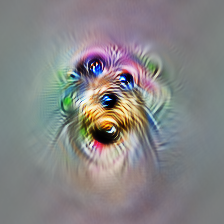

(13, 13)
(6, 6)
[(30.0, 193.0), (30.0, 193.0)]


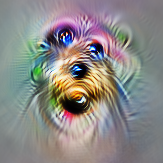

In [72]:
featviz_in_recep_field(deepcopy(sparse_circuits['cluster_0']),layer,0,margin=0)

------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 
        8               [13, 13]       15.5       16.0            99.0 
        9               [13, 13]       15.5       16.0           131.0 
        10              [13, 13]       15.5       16.0           131.0 
        11              [13, 13]       15.5       16.0   

100%|██████████| 512/512 [00:18<00:00, 27.59it/s]



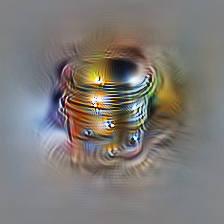

(13, 13)
(6, 6)
[(30.0, 193.0), (30.0, 193.0)]


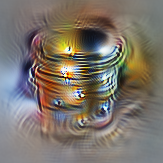

In [73]:
featviz_in_recep_field(deepcopy(sparse_circuits['cluster_1']),layer,0,margin=0)

#### Compare IoU of extracted circuits

In [104]:
from circuit_pruner.utils import plot_iou_from_masks

In [107]:
iou_fig = plot_iou_from_masks(sparse_masks['mixed_0'],sparse_masks['mixed_1'])

In [ ]:
iou_fig.update_layout(height = 350)

In [108]:
from circuit_pruner.visualizer.layouts import big_fig_layout

#iou_fig.update_layout(big_fig_layout)
#fig.update_layout({ 'width':3000})

fig.update_xaxes(title_standoff = 60)
fig.update_yaxes(title_standoff = 60)

iou_fig.update_layout({
                    'height':1500,
                    'width':1500,
                    'font':{'size':80}})

In [109]:
iou_fig.write_html("plots/905_mixed_iou.html")
iou_fig.write_image("plots/905_mixed_iou.svg")
iou_fig.write_image("plots/905_mixed_iou.png")

In [2]:
import math
math.floor(35/2)

17

#### make shuffled data

In [7]:
import os
from subprocess import call
import math
import random

#only works for 2 outfolders!!!

root_folder = '/mnt/data/chris/dropbox/Research-Hamblin/Projects/circuit_pruner_cvpr2022/image_data/sample_data/polysemantic/features_10:9/'

outfolders = ['mixed_1','mixed_2']

for outfolder in outfolders:
    if not os.path.exists(root_folder+outfolder):
        os.mkdir(root_folder+outfolder)

infolders = ['cluster_0','cluster_1']

max_num = 35

for infolder in infolders:
    fs = os.listdir(root_folder+infolder)
    random.shuffle(fs)
    for f in fs[0:math.floor(max_num/2)]:
        new_name = f.replace('.jpg','_'+infolder+'.jpg')
        call('cp %s %s'%(os.path.join(root_folder,infolder,f),os.path.join(root_folder,outfolders[0],new_name)),shell=True)
    for f in fs[math.floor(max_num/2):max_num]:
        new_name = f.replace('.jpg','_'+infolder+'.jpg')
        call('cp %s %s'%(os.path.join(root_folder,infolder,f),os.path.join(root_folder,outfolders[1],new_name)),shell=True)
        
    